## Git clone [BasicSR](https://github.com/xinntao/BasicSR) repo

In [1]:
!rm -rf BasicSR
!git clone https://github.com/xinntao/BasicSR.git
%cd BasicSR

Cloning into 'BasicSR'...
remote: Enumerating objects: 5487, done.
remote: Counting objects: 100% (1248/1248), done.
remote: Compressing objects: 100% (548/548), done.
remote: Total 5487 (delta 774), reused 1008 (delta 654), pack-reused 4239
Receiving objects: 100% (5487/5487), 3.64 MiB | 13.76 MiB/s, done.
Resolving deltas: 100% (3341/3341), done.
/content/BasicSR


## Set up the enviroment


In [2]:
# Install requirements
!pip install -r requirements.txt
# Install BasicSR without cuda extentions
!python setup.py develop

running develop
running egg_info
creating basicsr.egg-info
writing basicsr.egg-info/PKG-INFO
writing dependency_links to basicsr.egg-info/dependency_links.txt
writing requirements to basicsr.egg-info/requires.txt
writing top-level names to basicsr.egg-info/top_level.txt
writing manifest file 'basicsr.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'basicsr.egg-info/SOURCES.txt'
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:381: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/basicsr.egg-link (link to .)
basicsr 1.3.5 is already the active version in easy-install.pth

Installed /content/BasicSR
Processing dependencies for basicsr==1.3.5
Searching for yapf==0.32.0
Best match: yapf 0.32.0
Adding yapf 0.32.0 to easy-

## Download pretrained models

In [3]:
!python scripts/download_pretrained_models.py ESRGAN

Download 63.8 MB / 63.8 MB: 100% 2043/2043 [00:00<00:00, 2189.06chunk/s]
Download 63.8 MB / 63.8 MB: 100% 2043/2043 [00:00<00:00, 2727.54chunk/s]


## 1. Upload images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/
!rm -rf /content/FFHQ.zip
!rm -rf /content/selfie2anime.zip
!rm -rf /content/DIV2K_valid_HR.zip
!rm -rf /content/00000
!rm -rf /content/anime

!cp /content/drive/MyDrive/CSC413/FFHQ.zip /content/
!unzip /content/FFHQ.zip

!cp /content/drive/MyDrive/CSC413/selfie2anime.zip /content/
!unzip /content/selfie2anime.zip


!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!unzip /content/DIV2K_valid_HR.zip

In [6]:
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision import transforms
import torch
import glob
import os
def preprocess_image(image_path, model):
  img = read_image(image_path)
  if model == "SRCNN":
    lr_transform = transforms.Compose([transforms.Resize((img.shape[1] //2 , img.shape[2] // 2)), 
                                            transforms.Resize((img.shape[1], img.shape[2]))])
  elif model == "ESRGAN":
    lr_transform = transforms.Compose([transforms.Resize((img.shape[1] //2, img.shape[2] // 2))])

  tensor = lr_transform(torch.tensor(img / 255.))
  return tensor

## 2. Inference

In [7]:
def predict_pre_trained_ESRGAN(input_dict, dataset_name):
  # preprocess original image to downsample it
  %cd /content/
  input_list = sorted(glob.glob(os.path.join(input_dict, '*')))
  %rm -rf {dataset_name}_lr
  %rm -rf {dataset_name}_hr
  %mkdir {dataset_name}_lr
  %mkdir {dataset_name}_hr
  for input_path in input_list:
    save_image(preprocess_image(input_path, "ESRGAN"),  dataset_name + "_lr/" + os.path.basename(input_path))
  
  # predict using pre-trained model, output will be store at /content/{dataset_name}_hr
  %cd /content/BasicSR
  !python inference/inference_esrgan.py --model_path experiments/pretrained_models/ESRGAN/ESRGAN_SRx4_DF2KOST_official-ff704c30.pth --input /content/{dataset_name}_lr --output /content/{dataset_name}_hr

  # pre-trained model is x4 so we need to down sample again to match the original size
  output_list = sorted(glob.glob(os.path.join("/content/"+dataset_name+"_hr", '*')))
  for output_path in output_list:
    save_image(preprocess_image(output_path, "ESRGAN"),  output_path)

## 3. Visualize (Optional)

In [8]:
# visualize
import cv2
import matplotlib.pyplot as plt
import os
import glob

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def display(img1, img2, img3):
  fig = plt.figure(figsize=(15, 10))
  ax1 = fig.add_subplot(1, 3, 1) 
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 3, 2)
  plt.title('ESRGAN output', fontsize=16)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, 3, 3)
  plt.title('Original image', fontsize=16)
  ax3.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
  ax3.imshow(img3)


def compare_images(input_dict, dataset_name, num_image):  
  input_list = sorted(glob.glob(os.path.join("/content/"+dataset_name+"_lr", '*')))
  output_list = sorted(glob.glob(os.path.join("/content/"+dataset_name+"_hr", '*')))
  original_list = sorted(glob.glob(os.path.join(input_dict, '*')))
  for input_path, output_path, original_path in zip(input_list[:num_image], output_list[:num_image], original_list[:num_image]):
    img_input = imread(input_path)
    img_output = imread(output_path)
    img_original = imread(original_path)
    display(img_input, img_output, img_original)

/content


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


/content/BasicSR
Testing 0 0000
Testing 1 0001
Testing 2 0002
Testing 3 0003
Testing 4 0004
Testing 5 0005
Testing 6 0006
Testing 7 0007
Testing 8 0008
Testing 9 0009
Testing 10 0010
Testing 11 0011
Testing 12 0012
Testing 13 0013
Testing 14 0014
Testing 15 0015
Testing 16 0016
Testing 17 0017
Testing 18 0018
Testing 19 0019
Testing 20 0020
Testing 21 0021
Testing 22 0022
Testing 23 0023
Testing 24 0024
Testing 25 0025
Testing 26 0026
Testing 27 0027
Testing 28 0028
Testing 29 0029
Testing 30 0030
Testing 31 0031
Testing 32 0032
Testing 33 0033
Testing 34 0034
Testing 35 0035
Testing 36 0036
Testing 37 0037
Testing 38 0038
Testing 39 0039
Testing 40 0040
Testing 41 0041
Testing 42 0042
Testing 43 0043
Testing 44 0044
Testing 45 0045
Testing 46 0046
Testing 47 0047
Testing 48 0048
Testing 49 0049
Testing 50 0050
Testing 51 0051
Testing 52 0052
Testing 53 0053
Testing 54 0054
Testing 55 0055
Testing 56 0056
Testing 57 0057
Testing 58 0058
Testing 59 0059
Testing 60 0060
Testing 61 0061
T

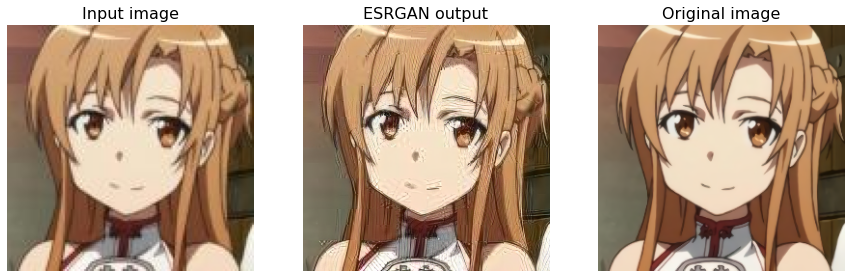

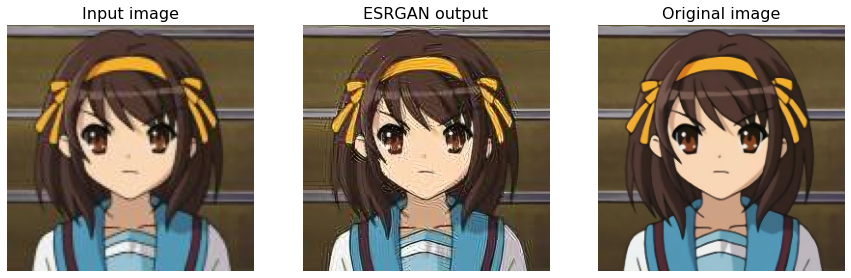

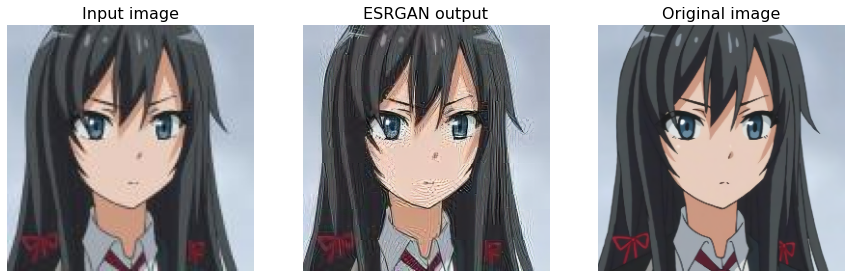

In [9]:
predict_pre_trained_ESRGAN("/content/anime", "anime")
compare_images("/content/anime", "anime", 3)

# Limitations
ESRGAN is mainly developped for research purpose and there are several limitations for practical usage. 
1. Scale. It now only supports for X4 upsampling. 
2. Kernel mismatch. The provided ESRGAN model is trained with MATLAB bicubic downsampling kernel (you can treat it as a blur type). If the blur type of the real image is different from the bicubic downsampling kernel, which is the usual case, the results are not satisfactory. You may need to fine-tune the pretrained ESRGAN model to improve the output quality.
3. Other degradations like JPEG compressions and noise. The pretrained ESRGAN model is for super-resolution, and does not take the JPEG compressions and noise into considerations. So it cannot handle these degradations. You may first remove theses degradations or fine-tune it to give this model such ability. 
